## Decision tree classification of Gaussian mixtures in Euclidean, hyperbolic and hyperspherical spaces

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import plot_tree
from sklearn.datasets import make_blobs
from sklearn.inspection import DecisionBoundaryDisplay

from geomstats.visualization import plot as gplot
from geomstats.geometry.hypersphere import Hypersphere

from hyperdt.toy_data import wrapped_normal_mixture
from hyperdt.tree import HyperbolicDecisionTreeClassifier
from hyperdt.visualization import plot_tree, plot_boundary
from hyperdt.QC_wrapped_normal_hypersphere import wrapped_normal_hypersphere

INFO: Using numpy backend


### Gaussian mixture in Euclidean space

In [3]:
# Generate Gaussian mixture data
X, y = make_blobs(n_samples=1000, n_features=2, centers=4, cluster_std=2.5, random_state=42)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

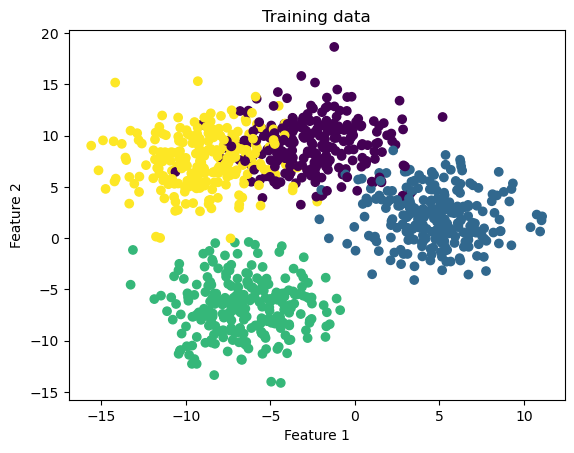

In [4]:
# Plot data
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Training data')
plt.show()

In [5]:
# Train decision tree classifier
dtc = DecisionTreeClassifier(random_state=42)
dtc.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [6]:
# Predict test set labels
y_pred = dtc.predict(X_test)

# Compute accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.91


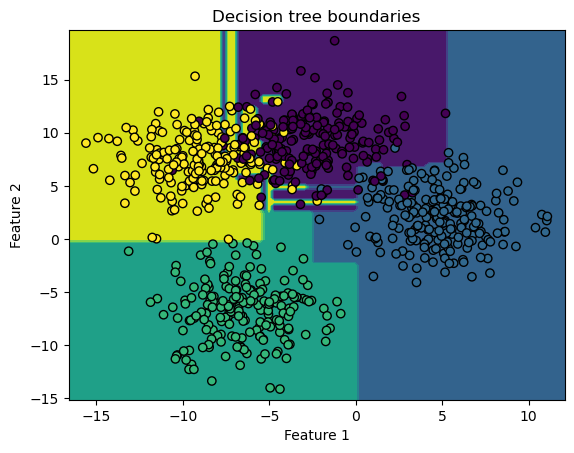

In [7]:
# Plot decision tree boundaries with training data
fig, ax = plt.subplots()
dbd = DecisionBoundaryDisplay.from_estimator(dtc, X_train, ax=ax)
dbd.plot(ax=ax)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Decision tree boundaries')
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='viridis', edgecolor='k')
plt.show()

### Gaussian mixture in hyperboloid space

In [8]:
# Generate Gaussian mixture data in hyperbolic space
X, y = wrapped_normal_mixture(num_points=1000, num_classes=4, noise_std=0.3, seed=2)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit hyperbolic decision tree classifier
hdt = HyperbolicDecisionTreeClassifier(timelike_dim=0, max_depth=2)
hdt.fit(X_train, y_train)

# Compute accuracy
hdt_score = hdt.score(X_test, y_test)
print(hdt_score)

0.755


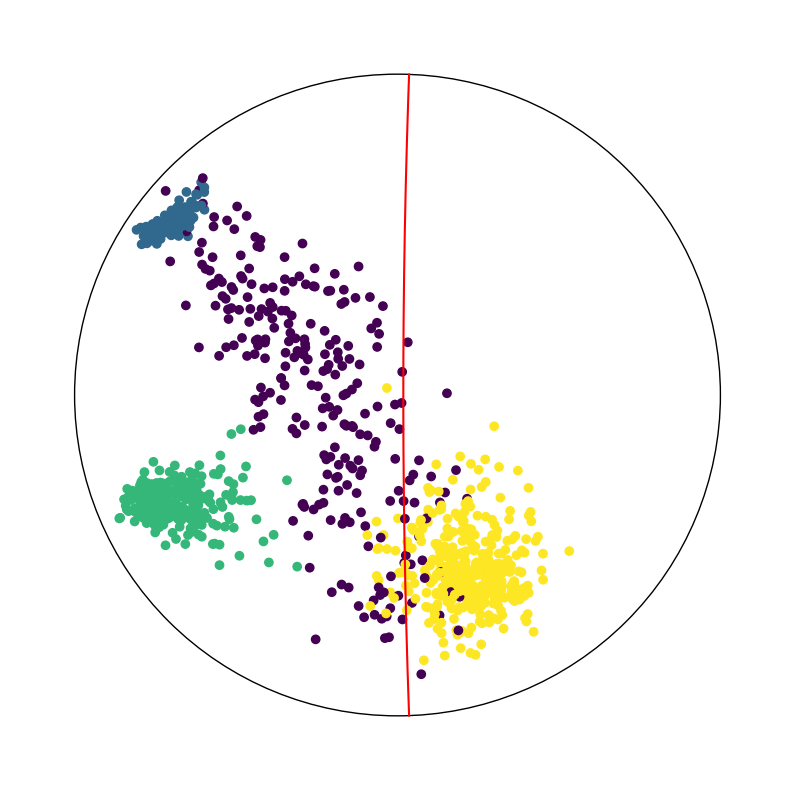

In [9]:
# Plot data and decision boundary
fig, ax = plt.subplots(figsize=(10, 10))
ax = gplot(X, c=y, space="H2_poincare_disk")
ax = plot_boundary(hdt.tree.feature, hdt.tree.theta, ax=ax)
plt.show()

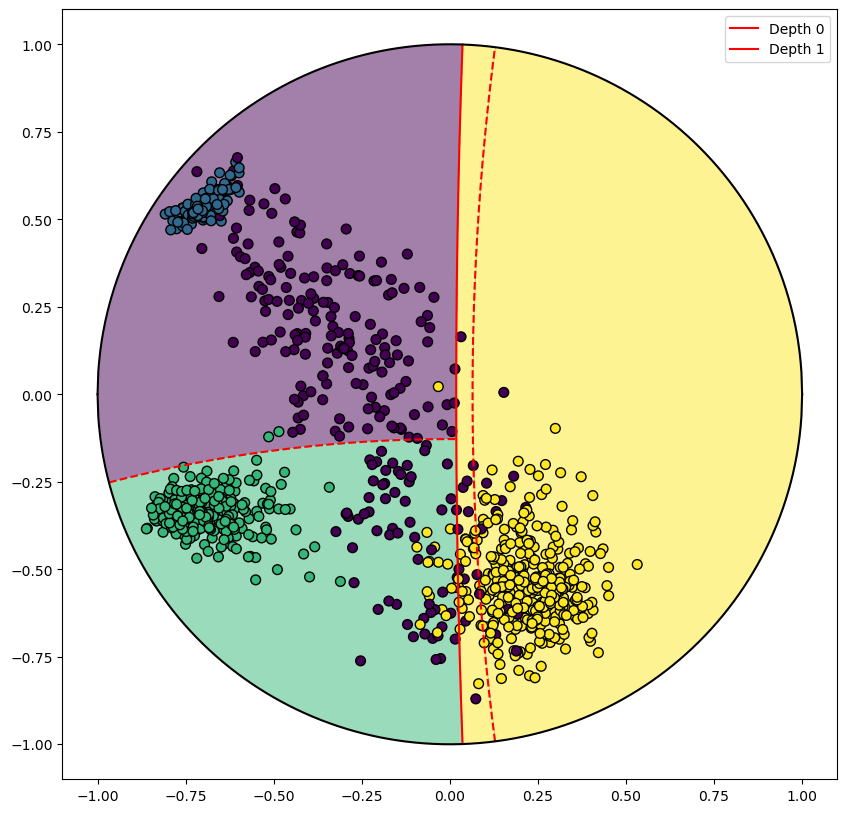

In [9]:
# Plot decision tree boundaries recursively
plot_tree(hdt, X=X, y=y)
plt.show()

### Gaussian mixture with von Mises-Fisher distribution in hyperspherical space

In [10]:
# Modified decision tree classifier for hypersphere data
class HypersphereDecisionTreeClassifier(HyperbolicDecisionTreeClassifier):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def _validate_hyperbolic(self, X):
        # Basically just skip the check
        pass

    def _get_candidates(self, X, dim):
        # Consider tangents
        thetas = np.arctan2(X[:, self.timelike_dim], X[:, dim])
        thetas = np.unique(thetas)  # This also sorts
        candidates = (thetas[:-1] + thetas[1:]) / 2
        return candidates

In [11]:
# Generate von Mises-Fisher data
def random_vmf(dim=2, means_kappa=1, n_means=3, min_kappa=10, max_kappa=20, n_samples=1000, seed=None):
    manifold = Hypersphere(dim=dim)

    if seed:
        np.random.seed(seed)

    means = manifold.random_von_mises_fisher(kappa=means_kappa, n_samples=n_means)
    kappas = np.random.uniform(min_kappa, max_kappa, size=n_means)

    points = []
    labels = []
    for sample in range(n_samples):
        idx = np.random.choice(range(n_means))
        mean = means[idx]
        kappa = kappas[idx]

        points.append(manifold.random_von_mises_fisher(mean, kappa))
        labels.append(idx)

    return np.array(points), np.array(labels)


points, labels = random_vmf(seed=42)

<Axes3D: xlabel='X', ylabel='Y', zlabel='Z'>

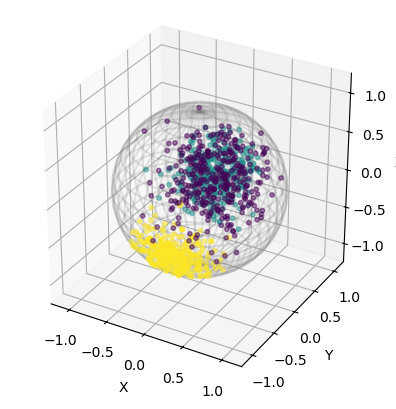

In [12]:
# Plot data in 3D
gplot(points, space="S2", marker="o", s=10, alpha=0.5, c=labels)

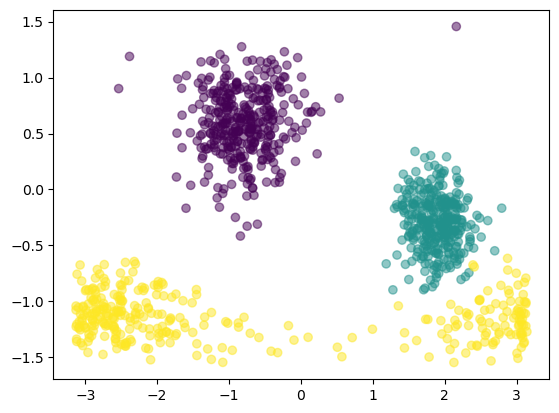

In [13]:
# Perform Mercator projection from 3D to 2D
def mercator_projection(points):
    """
    Perform Mercator projection from 3D to 2D for coordinates on a unit sphere.
    Assumes x, y, and z are NumPy arrays and ||x|| = 1.
    """

    # Calculate latitude (phi)
    phi = np.arcsin(points[:, 2])

    # Calculate longitude (lambda)
    lambda_ = np.arctan2(points[:, 1], points[:, 0])

    return np.stack([lambda_, phi], axis=1)


points_2d = mercator_projection(points)

plt.scatter(points_2d[:, 0], points_2d[:, 1], c=labels, alpha=0.5)

In [14]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(points, labels, test_size=0.2, random_state=0)

# Fit hypersphere decision tree classifier
hsdt = HypersphereDecisionTreeClassifier(max_depth=5)
hsdt.fit(X_train, y_train)
y_pred = hsdt.predict(X_test)
print("Hypersphere:", accuracy_score(y_test, y_pred))

Hypersphere: 0.98


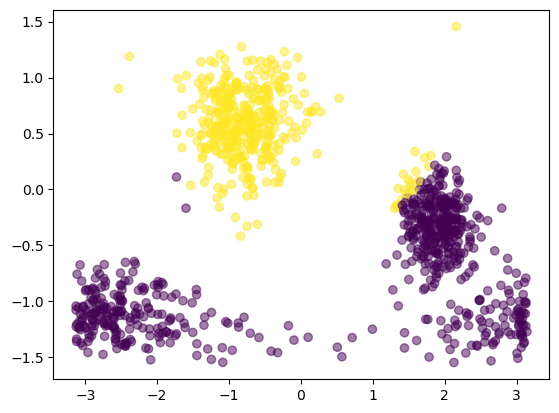

In [16]:
# Visualization [NEED TO UNDERSTAND]
node = hsdt.tree  # Can vary this
colors = np.sign(hsdt._dot(points, node.feature, node.theta))

plt.scatter(points_2d[:, 0], points_2d[:, 1], c=colors, alpha=0.5)

### Wrapped normal distribution distribution in hyperspheric space

In [16]:
# Generate Gaussian mixture data in hyperspheric space
X, y = wrapped_normal_hypersphere(num_points=1000, num_classes=4, noise_std=0.3, seed=2)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit hyperbolic decision tree classifier
hsdt2 = HypersphereDecisionTreeClassifier(max_depth=5)
hsdt2.fit(X_train, y_train)

# Compute accuracy
y_pred = hsdt2.predict(X_test)
print("Hypersphere:", accuracy_score(y_test, y_pred))

Hypersphere: 0.73


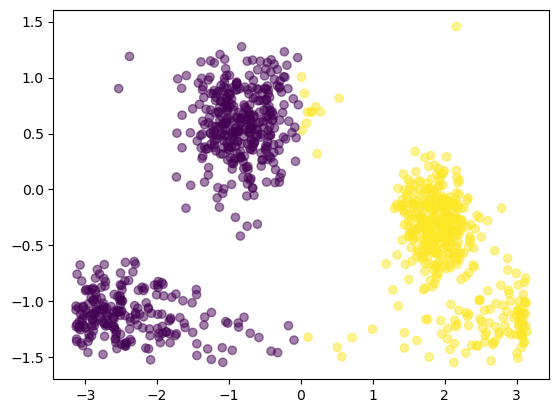

In [17]:
# Visualization [NEED TO UNDERSTAND]
node = hsdt2.tree  # Can vary this
colors = np.sign(hsdt2._dot(points, node.feature, node.theta))

plt.scatter(points_2d[:, 0], points_2d[:, 1], c=colors, alpha=0.5)